In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore')

from datetime import timedelta
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

import squarify
import matplotlib.cm as cm

**온라인 매장 행동 데이터**

In [2]:
# 대형 온라인 샵의 7개월(2019 10월 ~ 2020년 4월) 행동 데이터
big_behavior = pd.read_csv('ecommerce/2019-Nov.csv')

**Session group 클러스터링**

In [3]:
# 전체 데이터 세션에 따른 clustering 전처리
# 사용자 사이트 체류 시간에 대한 클러스터링

def user_session_clustering(new_data, current_data):

    # new_data가 비어 있는지 확인
    if new_data.empty:
        df = current_data
    else:
        df = pd.concat([new_data, current_data], axis=0)
    # 결측치 제거
    df.dropna(axis=0, inplace=True)

    # datetime화 시간대 정보 제거
    df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert(None)

    # 사이트 체류 시간 계산 위한 열 추출
    hd_df = df[['event_time', 'user_id', 'user_session', 'event_type']]

    # 동일한 세션에 대해 마지막, 처음 시간에 대한 df 생성
    max_group = hd_df.groupby(['user_session', 'user_id'], as_index=True)['event_time'].max()
    min_group = hd_df.groupby(['user_session', 'user_id'], as_index=True)['event_time'].min()

    # 열 이름 변경
    max_time_df = pd.DataFrame(max_group)
    max_time_df.columns = ['latest']
    
    min_time_df = pd.DataFrame(min_group)
    min_time_df.columns = ['start']

    # 두 df 연결
    session_df = pd.concat([max_time_df, min_time_df], axis=1)
    # 세션별 사이트 체류시간 계산
    session_df['session_time'] = session_df['latest'] - session_df['start']
    
    # 인덱스 컬럼화
    session_df.reset_index(drop=False, inplace=True)
    
    # 세션 중복값 제거
    session_df.drop_duplicates(subset='user_session', keep='first', inplace=True)

    # session_time 피처 지정
    feature='session_time'
    
    # 이상치로 인한 Robust Scaling
    scaler = RobustScaler()
    X = pd.DataFrame(
        scaler.fit_transform(session_df[[feature]]),
        columns=[feature]
    )
    # 엘보우 메서드 사용한 최적 클러스터 수 결정
    elbow = KElbowVisualizer(estimator=KMeans(random_state=20), k=10, locate_elbow=True)
    elbow.fit(X)
    
    # 최적 클러스터 수 저장
    optimal_clusters = elbow.elbow_value_
    
    # 최적 클러스터 수로 KMeans모델 피팅
    best_model = KMeans(n_clusters=elbow.elbow_value_, random_state=20)
    pred = best_model.fit_predict(X)
    
    # 클러스터링 레이블 data에 추가
    session_df['session_cluster'] = pred

    # 기존 데이터와 결합
    session_group = pd.merge(df, session_df, how='left')

    return session_group

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,latest,start,session_time,session_cluster
0,2019-11-01 00:00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2019-11-01 00:02:48,2019-11-01 00:00:00,0 days 00:02:48,0.0
1,2019-11-01 00:00:00,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2019-11-01 00:00:00,2019-11-01 00:00:00,0 days 00:00:00,0.0
2,2019-11-01 00:00:01,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,2019-11-01 00:00:01,2019-11-01 00:00:01,0 days 00:00:00,0.0
3,2019-11-01 00:00:01,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,2019-11-01 00:02:23,2019-11-01 00:00:01,0 days 00:02:22,0.0
4,2019-11-01 00:00:01,view,1306894,2053013558920217191,computers.notebook,hp,360.09,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c,2019-11-01 00:04:21,2019-11-01 00:00:01,0 days 00:04:20,0.0


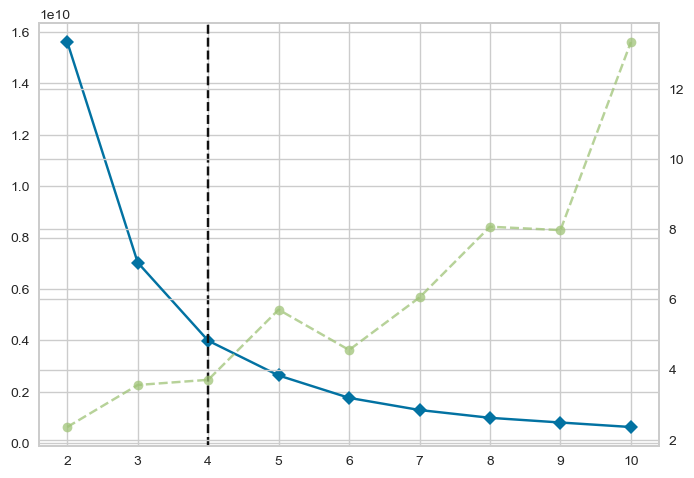

In [4]:
# new_data 생성 : 새로운 로그
new_data = pd.DataFrame(columns=big_behavior.columns.tolist())

# 함수 실행
session_group = user_session_clustering(new_data, big_behavior)
# 확인
session_group.head()

**<고객 그룹 정의>**
- Normal : 일반고객
- Lost : 이탈고객
- hibernating : 동면고객
- Lisk : 이탈 우려 고객
- Need Attention: 놓치면 안되는 고객
- Dormant : 휴면 예정 고객
- New  : 신규고객
- Promising : 모든 수치가 평균인 고객
- Recent Users : 관리 필요한 고객 - 최근 방문, but 자주 방문 x, 많은 시간 소요 x
- Potential Loyal : 잠재충성고객
- Loyal : 충성고객
- Potential Champions : 잠재 vip
- Champions : vip 

In [7]:
# 데이터 전처리 파이프라인
# RFM 계산
def rfm_calculate(df):
    # 결측치 제거
    df.dropna(axis=0, inplace=True)
    
    # 구매 이력 있는 행만 추출해 buy_df 데이터프레임 생성
    buy_df = df.loc[df['event_type'] == 'purchase']
    
    # 사용자 세션에 따른 최근 주문 날짜, 고객 id, 세션 수, 매출
    buy_df = buy_df.groupby(by='user_session').agg(
    order_date=('event_time', 'max'),  # 최대 날짜
    user_id=('user_id', lambda x: x.unique()[0]),  # user_id
    Quantity=('user_session', 'count'),  # 세션 수 카운트
    money_spent=('price', 'sum')  # 가격의 합계
).reset_index(drop=True)

    # 마지막 구매일 다음 날짜를 구해 구매 날짜 간 차이 계산
    study_date = buy_df['order_date'].max() + pd.Timedelta(days=1)
    buy_df=pd.DataFrame(buy_df)
    buy_df['last_purchase'] = study_date - buy_df['order_date']
    buy_df['last_purchase'] = buy_df['last_purchase'].dt.days

    # RFM 계산 : 사용자 id에 따른 구매 최소 기간, 빈도, 금액 량
    rfm = buy_df.groupby('user_id').agg(
        Recency=('last_purchase', 'min'),
        Frequency=('user_id', 'count'),
        Monetary=('money_spent', 'sum')
    )
    return rfm

In [8]:
# 함수 실행
rfm_df = rfm_calculate(session_group)
# 확인
rfm_df.head()

,Recency,Frequency,Monetary
user_id,,,
225644257,19,1,40.91
253299396,25,1,246.85
256164170,11,1,113.23
296197073,1,1,51.46
299358698,22,1,154.19


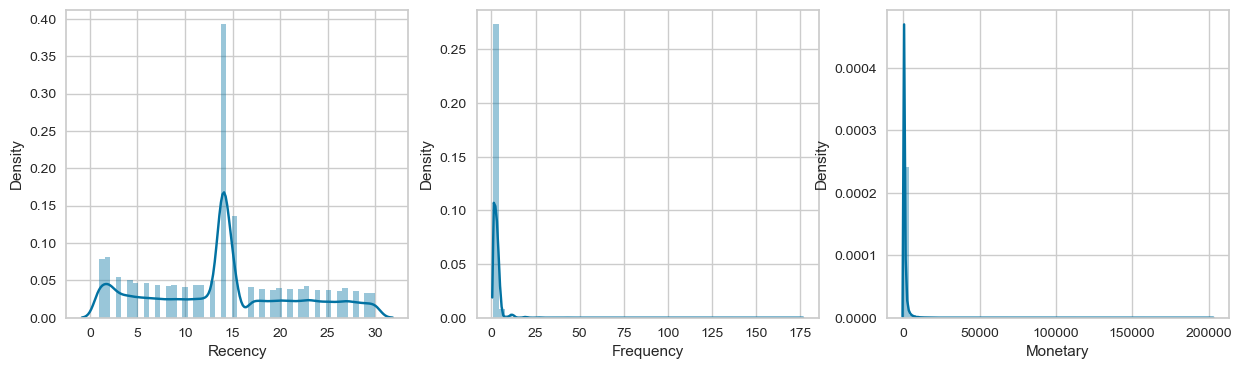

In [9]:
# RFM 분포 확인
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes = axes.flatten()

for col, ax in zip(['Recency', 'Frequency', 'Monetary'], axes):
    sns.distplot(rfm_df[col], ax = ax)
    
plt.show()

In [10]:
# 자동 군집 후, 실루엣 계수 시각화 함수
def visualize_silhouette(data):
    # 특징값 스케일링
    features=['Recency', 'Frequency', 'Monetary']
    scaler = MinMaxScaler()
    X = pd.DataFrame(
        scaler.fit_transform(data[features]),
        columns=features
    )
    # 엘보우 메서드 사용한 최적 클러스터 수 결정
    elbow = KElbowVisualizer(estimator=KMeans(random_state=20), k=10, locate_elbow=True)
    elbow.fit(X)
    
    # 최적 클러스터 수 저장
    optimal_clusters = elbow.elbow_value_

    # plt.figure()로 단일 figure 생성
    plt.figure(figsize=(4, 4))

    # 최적 클러스터 수로 KMeans모델 피팅
    cluster = KMeans(n_clusters=optimal_clusters, random_state=20)
    cluster_labels = cluster.fit_predict(X)
    
    # 클러스터 레이블에 대해 실루엣 스코어와 개별 데이터의 실루엣 값 계산
    sil_avg = silhouette_score(X, cluster_labels)
    sil_values = silhouette_samples(X, cluster_labels)
    
    # 실루엣 점수 시각화
    plt.title('Number of Cluster: ' + str(optimal_clusters) + '\n' +
              'Silhouette Score: ' + str(round(sil_avg, 3)))
    
    y_lower = 10

    # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
    for i in range(optimal_clusters):
        ith_cluster_sil_values = sil_values[cluster_labels == i]
        ith_cluster_sil_values.sort()
        
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / optimal_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, 
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.axvline(x=sil_avg, color="red", linestyle="--")    # 평균 실루엣 점수 선
    plt.show()

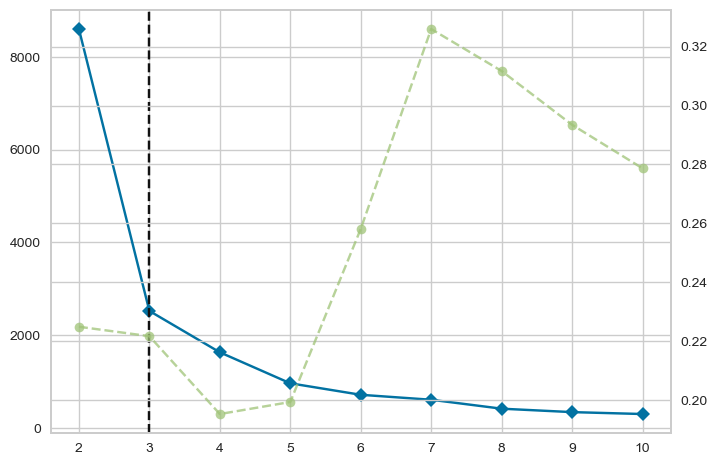

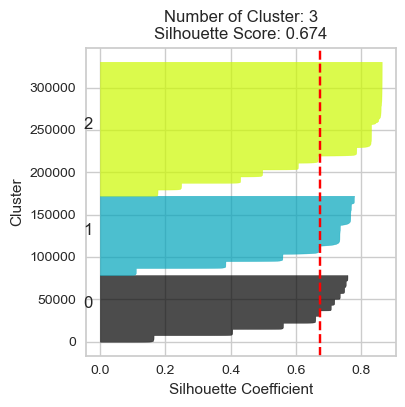

In [11]:
# 로그 변환 전 min_max scaler 적용 후, 클러스터링
rfm_df1 = rfm_df.copy()
visualize_silhouette(rfm_df)

- 왜곡이 심한 Frequency, Monetary는 로그 변환 적용

In [12]:
rfm_df2 = rfm_df.copy()
# 로그 변환 적용
rfm_df2['Frequency'] = np.log(rfm_df2['Frequency'])
rfm_df2['Monetary'] = np.log(rfm_df2['Monetary'])

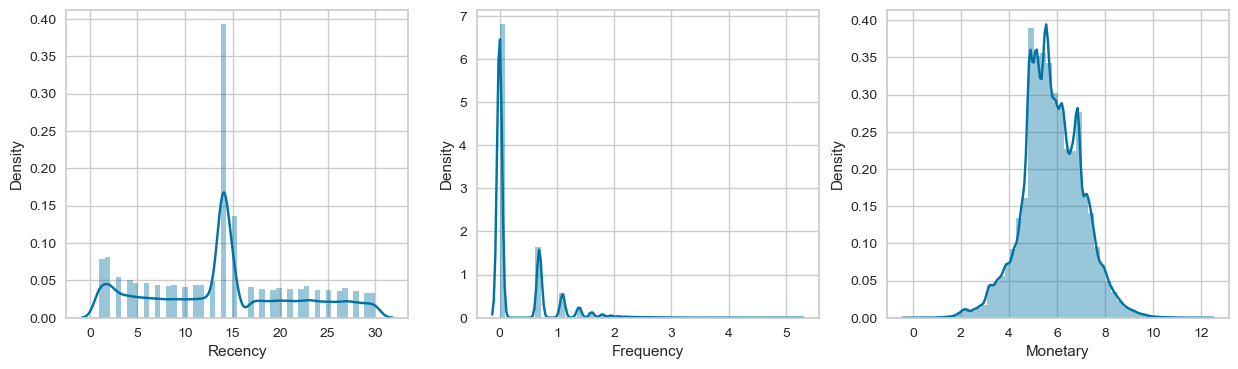

In [13]:
# RFM 분포 확인
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes = axes.flatten()

for col, ax in zip(['Recency', 'Frequency', 'Monetary'], axes):
    sns.distplot(rfm_df2[col], ax = ax)
    
plt.show()

- 로그 변환을 통해 왜곡정도의 개선을 확인할 수 있음

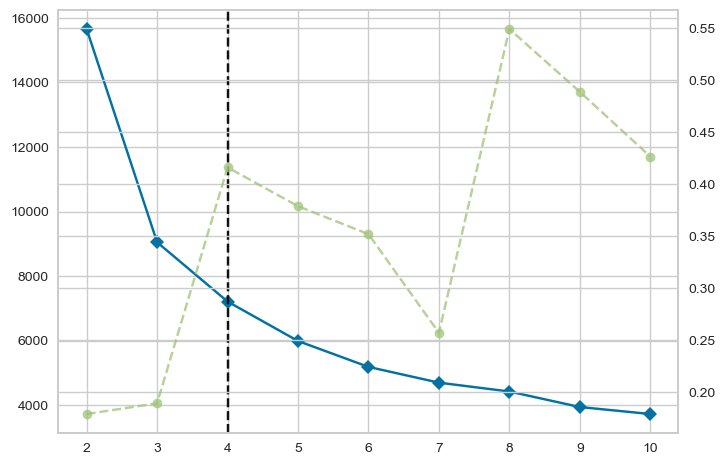

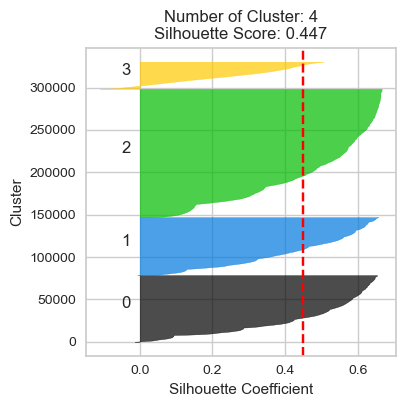

In [14]:
# 로그 변환 후 min_max scaler 적용 후, 클러스터링
visualize_silhouette(rfm_df2)

- MinMax Scaler 한 실루엣 계수가 더 높고 규칙적이었음 -> 로그 변환 없이 클러스터링 하는 것으로 결정하게 됨(군집 수는 Elbow Method를 사용해 3개로 설정)

In [15]:
# 데이터 전처리 파이프라인
# 로그변환 & RFM 분석 적용한 고객 등급, 그룹 분류 함수
# 함수 내 session_group <- 전처리 전 데이터
def rfm_segment(data):
    
    # 특징값 스케일링
    features=['Recency', 'Frequency', 'Monetary']
    scaler = MinMaxScaler()
    X = pd.DataFrame(
        scaler.fit_transform(data[features]),
        columns=features
    )
    # 엘보우 메서드 사용한 최적 클러스터 수 결정
    elbow = KElbowVisualizer(estimator=KMeans(random_state=20), k=10, locate_elbow=True, display=False)
    elbow.fit(X)

    # 최적 클러스터 수로 KMeans모델 피팅
    best_model = KMeans(n_clusters=elbow.elbow_value_, random_state=20)
    pred = best_model.fit_predict(X)
    
    # 클러스터 레이블 -> rfm df(RFM한 df)에 추가
    data['cluster'] = pred

    # rfm df에 RFM 점수를 계산해 추가하는 함수
    def update_score(df: pd.DataFrame, features: list, bins: int=5) -> pd.DataFrame:
        # 가중치 계산하는 내부 함수
        def get_w(result_only: bool=False) -> tuple:
            # 각 클러스터의 평균 및 표준편차 계산
            summary_df = df.pivot_table(index='cluster', values=features, aggfunc=['mean', 'std'])
            
            clusters = list(range(len(summary_df)))
    
            # 변동계수 계산
            CV_R = [summary_df[('std', 'Recency')][i] / summary_df[('mean', 'Recency')][i] for i in clusters]
            CV_F = [summary_df[('std', 'Frequency')][i] / summary_df[('mean', 'Frequency')][i] for i in clusters]
            CV_M = [summary_df[('std', 'Monetary')][i] / summary_df[('mean', 'Monetary')][i] for i in clusters]
    
            # 가중치 계산
            w1 = np.min(CV_R) / np.sum(CV_R)
            w2 = np.min(CV_F) / np.sum(CV_F)
            w3 = np.min(CV_M) / np.sum(CV_M)
    
            # 정규화된 가중치
            W1 = (w1) / (w1 + w2 + w3)
            W2 = (w2) / (w1 + w2 + w3)
            W3 = (w3) / (w1 + w2 + w3)
    
            if result_only:
                return (W1, W2, W3)
            else:
                # 결과 출력
                display(summary_df)
                display(pd.DataFrame({'CV_r': CV_R, 'CV_f': CV_F, 'CV_m': CV_M}).rename_axis('cluster'))
                display(pd.DataFrame({'w_1': [w1], 'w_2': [w2], 'w_3': [w3]}))
                display(pd.DataFrame({'W_1': [W1], 'W_2': [W2], 'W_3': [W3]}))
    
        # 가중치 계산
        w1, w2, w3 = get_w(result_only=True)
    
        # Recency 고유 값 수 확인
        unique_recency = df['Recency'].nunique()
        r_labels = min(bins, unique_recency)
    
        # R-Score 계산
        try:
            df['R-Score'] = pd.qcut(df['Recency'], q=bins, labels=range(r_labels, 0, -1), duplicates='drop')
        except ValueError as e:
            print(f"Recency qcut error: {e}")
            df['R-Score'] = pd.cut(df['Recency'], bins=min(bins, len(df['Recency'].unique())), labels=range(min(bins, len(df['Recency'].unique())), 0, -1))
    
        # Frequency에 대한 F-Score 계산
        df['F-Score'] = df['Frequency'].apply(lambda x: 1 if x == 1 else 2)
    
        # Monetary 고유 값 수 확인
        unique_monetary = df['Monetary'].nunique()
        m_labels = min(bins, unique_monetary)
    
        # M-Score 계산
        try:
            df['M-Score'] = pd.qcut(df['Monetary'], q=bins, labels=range(1, m_labels + 1), duplicates='drop')
        except ValueError as e:
            print(f"Monetary qcut error: {e}")
            df['M-Score'] = pd.cut(df['Monetary'], bins=min(bins, len(df['Monetary'].unique())), labels=range(1, min(bins, len(df['Monetary'].unique())) + 1))
    
        # RFM Score 계산
        df['RFM Score'] = (w1 * df['R-Score'].astype(int) / bins + 
                           w2 * df['F-Score'].astype(int) / 2 + 
                           w3 * df['M-Score'].astype(int) / bins) * 100
        
        return df
    
    # update_score 함수 사용해 rfm score 계산
    update_rfm = update_score(data, features)

    # 경계값 설정
    Q2 = update_rfm['RFM Score'].median()
    Q3 = update_rfm['RFM Score'].describe()[6]
    
    # 경계 점수에 의한 고객 등급 설정
    update_rfm['customer_grade'] = pd.cut(update_rfm['RFM Score'], bins=[0, Q2, Q3, 100], labels=['Silver', 'Gold', 'Platinum'])
    update_rfm = update_rfm.reset_index()
    
    # rfm score에 의한 고객 그룹화
    def rfm_group(df):
        if df['R-Score'] == 5 and df['F-Score'] == 2 and df['M-Score'] >= 4:
            return 'Champions'
        elif df['R-Score'] == 5 and df['F-Score'] == 2 and df['M-Score'] < 4:
            return 'Potential Champions'
        elif df['R-Score'] == 4 and df['F-Score'] == 2 and df['M-Score'] >= 4:
            return 'Loyal'
        elif df['R-Score'] == 4 and df['F-Score'] == 2 and df['M-Score'] < 4:
            return 'Potential Loyal'
        elif df['R-Score'] >= 4 and df['F-Score'] == 1:
            return 'Recent Users'
        elif df['R-Score'] == 3 and df['F-Score'] == 2 and df['M-Score'] >= 3:
            return 'Promising'
        elif df['R-Score'] == 3 and df['F-Score'] == 1 and df['M-Score'] >= 3:
            return 'New'
        elif df['R-Score'] == 2 and df['F-Score'] == 2 and df['M-Score'] <= 5:
            return 'Dormant'
        elif df['R-Score'] == 3 and df['F-Score'] == 2 and df['M-Score'] == 2:
            return 'Need Attention'
        elif df['R-Score'] == 3 and df['F-Score'] == 1 and df['M-Score'] < 3:
            return 'Lisk'
        elif df['R-Score'] <= 2 and df['F-Score'] == 2 and df['M-Score'] <= 2:
            return 'hibernating'
        elif df['R-Score'] <= 2  and df['F-Score'] == 1 and df['M-Score'] <= 5:
            return 'Lost'
        else:
            return 'Normal'

    # 적용
    update_rfm['custor_segment'] = update_rfm.apply(rfm_group, axis=1)

    # 분류 그룹의 평균 수치, 고객 수 정보 df
    RFM_desc = update_rfm.groupby('custor_segment').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(1)
    RFM_desc.columns = ['Recency Mean','Frequency Mean','Monetary Mean', 'Count']

    # 사용자 id를 기준으로 구매한 고객 그룹 데이터 
    user_rfm = pd.merge(update_rfm, session_group.loc[session_group['event_type'] == 'purchase'], on='user_id', how='left')
    
    return user_rfm, update_rfm, RFM_desc

Recency qcut error: Bin labels must be one fewer than the number of bin edges


,user_id,Recency,Frequency,Monetary,cluster,R-Score,F-Score,M-Score,RFM Score,customer_grade,...,product_id,category_id,category_code,brand,price,user_session,latest,start,session_time,session_cluster
0,225644257,19,1,40.91,2,2,1,1,35.298830,Silver,...,6800309,2053013554222596431,computers.components.hdd,toshiba,40.91,3601c672-9a75-4627-b9be-576298187981,2019-11-12 04:20:47,2019-11-12 04:13:58,0 days 00:06:49,0.0
1,253299396,25,1,246.85,0,1,1,3,47.482018,Silver,...,2400724,2053013563743667055,appliances.kitchen.hood,bosch,246.85,e38b620b-6024-44e8-9db8-81a3a5b0e7e7,2019-11-06 10:53:31,2019-11-06 10:46:09,0 days 00:07:22,0.0
2,256164170,11,1,113.23,2,4,1,1,44.200876,Silver,...,3900975,2053013552326770905,appliances.environment.water_heater,ariston,113.23,56bbfca9-4dab-4d43-adf7-a47ea1ae8000,2019-11-20 08:21:14,2019-11-20 08:10:54,0 days 00:10:20,0.0


,user_id,Recency,Frequency,Monetary,cluster,R-Score,F-Score,M-Score,RFM Score,customer_grade,custor_segment
0,225644257,19,1,40.91,2,2,1,1,35.298830,Silver,Lost
1,253299396,25,1,246.85,0,1,1,3,47.482018,Silver,Lost
2,256164170,11,1,113.23,2,4,1,1,44.200876,Silver,Recent Users


,Recency Mean,Frequency Mean,Monetary Mean,Count
custor_segment,,,,
Champions,3.0,5.0,2763.6,23169
Dormant,21.4,2.8,1243.0,10363
Lisk,14.6,1.0,128.1,45901


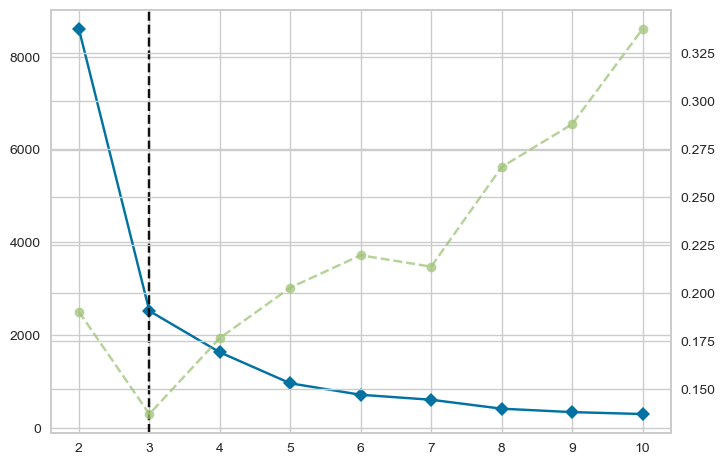

In [16]:
# 함수 실행
user_rfm, update_rfm, RFM_desc = rfm_segment(rfm_df)

# 확인
display(user_rfm.head(3))
display(update_rfm.head(3))
display(RFM_desc.head(3))

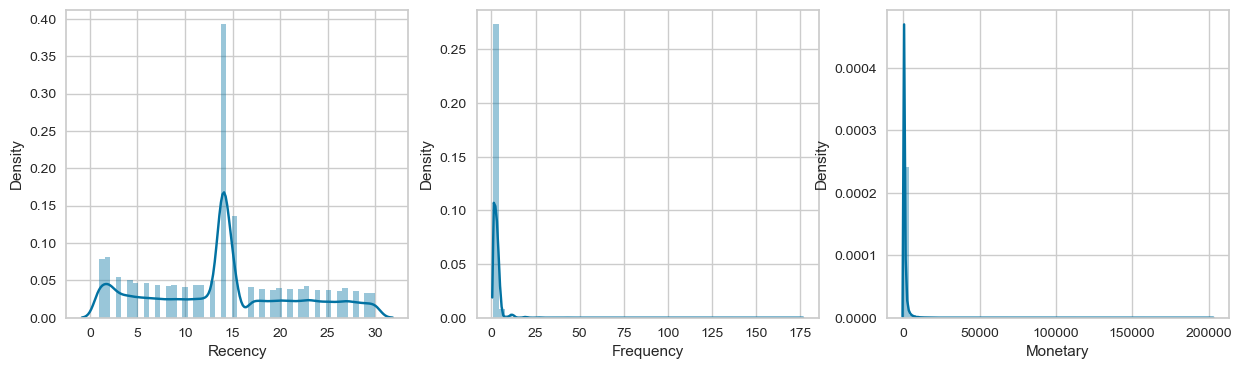

In [17]:
# RFM 분포 확인
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes = axes.flatten()

for col, ax in zip(['Recency', 'Frequency', 'Monetary'], axes):
    sns.distplot(update_rfm[col], ax = ax)
    
plt.show()

In [18]:
# 등급 별 구매액 확인
print('Normal 구매액:', user_rfm[user_rfm['customer_grade']=='Silver']['price'].sum())
print('Gold 구매액:', user_rfm[user_rfm['customer_grade']=='Gold']['price'].sum())
print('Platinum 구매액:', user_rfm[user_rfm['customer_grade']=='Platinum']['price'].sum())

Normal 구매액: 33628309.660000004
Gold 구매액: 50278406.62
Platinum 구매액: 157652429.83


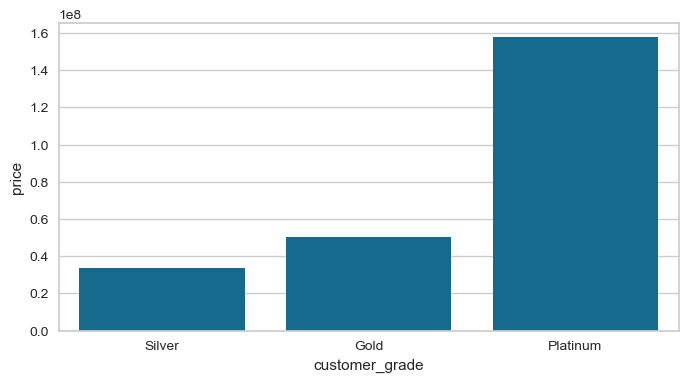

In [19]:
# 등급 별 총 구매액 분포 확인
price_temp = user_rfm.groupby('customer_grade', as_index=False)['price'].sum()
plt.figure(figsize=(8, 4))
sns.barplot(x='customer_grade', y='price', data=price_temp)
plt.show()

- Platinum이 매출의 많은 부분 차지

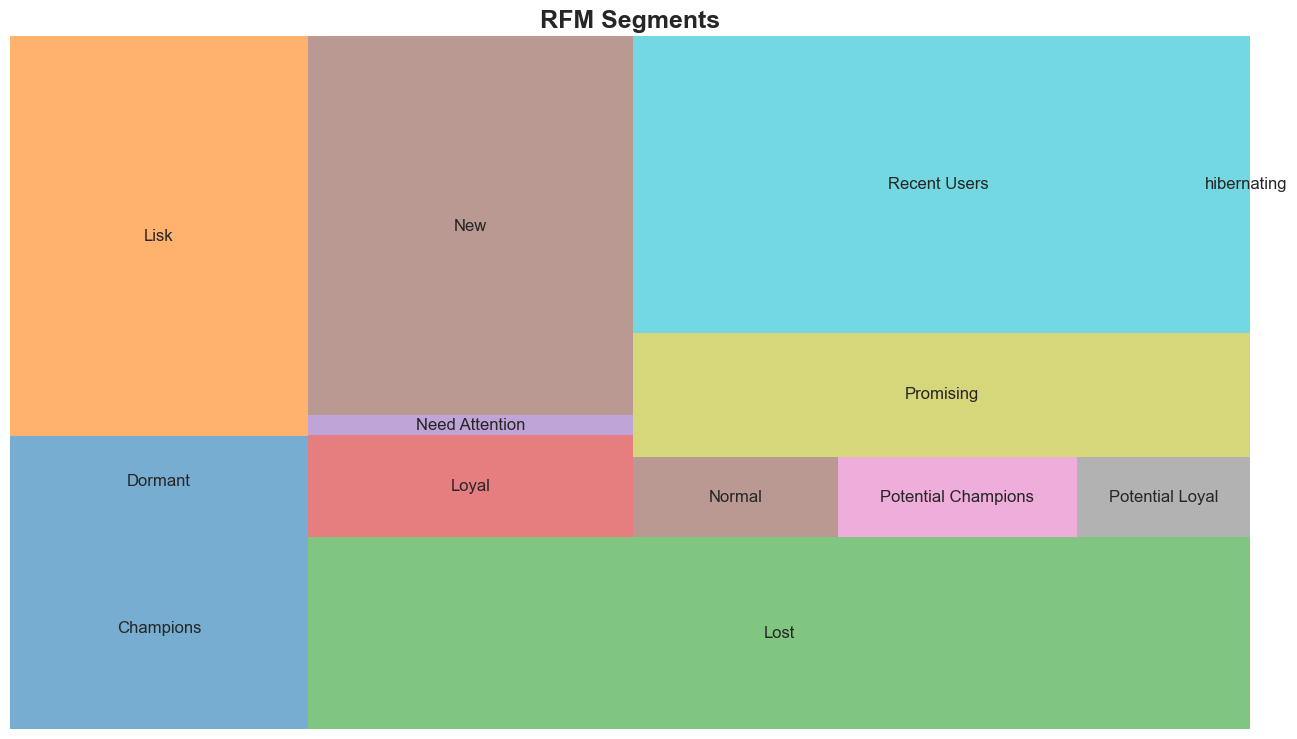

In [20]:
# 고객 그룹 세그먼트 그래프
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)

colors = cm.tab10(np.linspace(0, 1, len(RFM_desc)))
squarify.plot(sizes=RFM_desc['Count'], 
              label=list(RFM_desc.index), 
              color=colors, alpha=.6)

plt.title("RFM Segments", fontsize=18, fontweight="bold")
plt.axis('off')
plt.show()

In [21]:
# rfm한 유저 데이터 저장
user_rfm.to_csv('usr_rfm.csv', index=False)

# 세션 clustering한 유저 데이터 저장
session_group.to_csv('session_group.csv', index=False)